In [1]:
from math import log,exp,fsum
from data import load_mnist,load_synth
import numpy as np
import matplotlib.pyplot as plt 
import random


In [2]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid(x):
  return 1 / (1 + np.exp(-x))  

def softmax(o):
  """
    Parameters:
      -o : vector of softmax input
      -i : index i of numerator 
  """
  o = o.reshape(o.shape[1],1)
  return (np.exp(o) / fsum(np.exp(o))).T

def cross_entropy_loss(y, true_y):
    """
    Parameters:
        -y: vector output of softmax
        -true_y: true target value (or index)
    """
    
    # ytrain goes from 0 to 9
    return -log(y[0][true_y])  


In [53]:
class DNN:
    def __init__(self):
        self.x = None #first layer input nodes
        self.W = None #first layer weights matrix
        self.b = None #input bias
        self.k = None #first layer linear output
        self.h = None #sigmoid activation output
        self.V = None #second layer weight matrix
        self.c = None #second layer bias
        self.o = None #softmax input
        self.y = None #softmax output
        self.t = None #target vector        

        # (self.xtrain, self.ytrain), (self.xval, self.yval), self.num_cls = load_synth()

    def default_init(self,final=False):
        self.set_nodes()
        self.set_weights_W()
        self.set_weights_V()
        self.set_bias()
        (self.xtrain, self.ytrain), (self.xval, self.yval), self.num_cls = load_mnist(final=final)

    def load_mnist(self,final=False):
        (self.xtrain, self.ytrain), (self.xval, self.yval), self.num_cls = load_mnist(final=final)
        # (self.xtrain, self.ytrain), (self.xval, self.yval), self.num_cls = load_synth()
    def set_nodes(self,x=784,k=300,h=300,o=10,y=10):
        """
        Inititalize list of nodes with specific sizes
        Also works for reset values for a new fordward pass
        Parameters:
            x: size of first layer input nodes
            k: size of first layer linear output
            h: size of sigmoid nodes layer
            o: size of softmax input layer
            y: size of softmax output layer
        """
        self.x = np.zeros((1,x))
        self.k = np.zeros((1,k))
        self.h = np.zeros((1,h))
        self.o = np.zeros((1,o))
        self.y = np.zeros((1,y))

    def set_weights_W(self,mu=0.0,sigma=1.0):
        """
        Initialize weights matrix W
        Parameters:
            -mu     : mean of the normal distribution from where the random weights are generated
            -sigma  : standar deviation of the normal distribution from where the random weights are generated
        """
        n_xcols = np.shape(self.x)[1]
        n_kcols = np.shape(self.k)[1]
        
        self.W = np.random.normal(loc=mu,scale=sigma,size=(n_xcols,n_kcols))
        # self.W = np.array([[1., 1.,1.], [-1.,-1.,-1.]])

    def set_weights_V(self,mu=0.0,sigma=1.0):
        """
        Initialize weights matrix V
        Parameters:
            -mu     : mean of the normal distribution from where the random weights are generated
            -sigma  : standar deviation of the normal distribution from where the random weights are generated
        """
        n_hcols = np.shape(self.h)[1]
        n_ocols = np.shape(self.o)[1]
        self.V = np.random.normal(loc=mu,scale=sigma,size=(n_hcols,n_ocols))
        # self.V = np.array([[1., 1.], [-1.,-1.],[-1.,-1.]])

    def set_bias(self,b=300,c=10):
        #bias
        self.b = np.zeros((1,b))
        self.c = np.zeros((1,c))
    
    def set_derivative_lists(self):

        y_rows = np.shape(self.y)[1]
        o_rows = np.shape(self.o)[1]
        h_rows = np.shape(self.h)[1]
        k_rows = np.shape(self.k)[1]
        x_rows = np.shape(self.x)[1]

        self.dl_dy = np.zeros((y_rows,1))                                #derivatives of the loss wrt softmax output
        self.dy_do = np.zeros((y_rows,o_rows))                           #derivatives of the softmax output wrt softmax input
        self.dl_do = np.zeros((1,o_rows))                                #derivatives of the loss wrt softmax input
        self.do_dh = np.zeros((o_rows,h_rows))                           #derivatives of the softmax input wrt to sigmoid output
        self.dl_dh = np.zeros((1,h_rows))                                #derivatives of the loss wrt sigmoid output
        self.do_dv = np.zeros((o_rows,))
        self.dl_dv = np.zeros((h_rows,o_rows))                           #derivatives of the loss wrt to weights V
        self.dl_dc = np.zeros((1,o_rows))                                #derivatives of the loss wrt to bias C
        self.dl_dk = np.zeros((1,k_rows))                                #derivatives of the loss wrt to sigmoid input
        self.dh_dk = np.zeros((1,k_rows))                                #derivatives of the sigmoid output wrt to sigmoid input (only interested in same i-index e.g dHi/dK))
        self.dl_dw = np.zeros((k_rows,x_rows))                           #derivatives of the loss wrt to weights W
        self.dl_db = np.zeros((1,k_rows))                                #derivatives of the loss wrt to bias B        

    def onehot_encode_true_y(self):
        """
        Creates a matrix of size (n,n) fulls of zeros except from the last column and i-th row, where i is the index of the target
        """
        encoded = np.zeros(self.y.shape,dtype=int)

        encoded[0,self.t] = 1

        return  encoded

    def gradient_dy_do(self):
        y_ = self.y.reshape(-1,1)

        return np.diagflat(y_) - np.dot(y_, y_.T)    

    def forward_pass(self,x,true_y,verbose=False):
        # self.set_nodes(x=2,k=3,h=3,o=2,y=2)
        self.set_nodes()
        self.x = x.reshape(1,x.shape[0])
        self.t = true_y

        # print(f"{self.x.shape} dot {self.W.shape}")
        self.k = (self.x.dot(self.W)) + self.b

        self.h = sigmoid(self.k)

        self.o = (self.h.dot(self.V)) + self.c

        self.y = softmax(self.o)
        # if verbose: self.report_f()

        loss = cross_entropy_loss(self.y,self.t)

        if verbose: self.report_f(target=self.t,loss=loss)
        
        return loss        
    
    def backward_pass(self,alpha=0.01,verbose=False):
        self.set_derivative_lists()
        true_y_encoded = self.onehot_encode_true_y() # TODO: OJO CON ESTO AL PASAR A RED GRANDE
        
        # print(f"encoded: {true_y_encoded.tolist()} \t shape: {true_y_encoded.shape}")

        self.dl_dy = (-1/self.y)*true_y_encoded
        
        self.dy_do = self.gradient_dy_do()

        self.dl_do = self.dl_dy.dot(self.dy_do)

        self.do_dh = self.V.T

        self.dl_dv = (self.h.reshape(self.h.shape[1],1)).dot(self.dl_do) 
        
        self.dl_dc = self.dl_do

        self.dl_dh = self.dl_do.dot(self.do_dh)

        self.dh_dk = sigmoid(self.k)*(1-sigmoid(self.k))
        
        self.dl_dk = self.dl_dh * self.dh_dk # TODO: OJO DE AQUI YA N ESTOY SEHURO

        self.dl_dw = (self.x.reshape(self.x.shape[1],1)).dot(self.dl_dk)

        self.dl_db = self.dl_dk

        if verbose: self.report_derivs()
    
    def update(self, alpha=0.01,verbose=False):

        self.W = self.W - alpha * self.dl_dw
        self.V = self.V - alpha * self.dl_dv

        self.b = self.b - (alpha * self.dl_db)
        self.c = self.c - (alpha * self.dl_dc)        
        
        if verbose: self.report_update()        

    def train_epoch(self,alpha=0.02,rounds=None,verbose=False,epochs=1):
        self.all_losses = []
        self.epochs_avg_loss = []
        
        counter = 0

        for _ in range(epochs):
            epoch_losses = []
            for x,true_y in zip(self.xtrain,self.ytrain):
                # target_i = [0,1] if self.ytrain[i] == 0 else [1,0]
                
                # x=np.array([1,-1])
                # true_y = 0
                loss = self.forward_pass(x,true_y,verbose=verbose)
                self.backward_pass(alpha=alpha,verbose=verbose)
                self.update(alpha=alpha,verbose=verbose)
                
                self.all_losses.append(loss)
                epoch_losses.append(loss)

                if rounds != None:
                    if counter < rounds:
                        counter += 1
                    else:
                        break

            self.epochs_avg_loss.append(np.mean(epoch_losses))

        print(f"epoch avgs: {self.epochs_avg_loss}")

    def make_predictions(self,rounds=None,verbose=False):
        self.predictions_loss = []
        for x,true_y in zip(self.xval,self.yval):        
            loss = self.forward_pass(x,true_y,verbose=verbose)
            
            self.predictions_loss.append(loss)
            if rounds != None:
                if counter < rounds:
                    counter += 1
                else:
                    break            


    def report_f(self,target=[0,0],loss=0):
        print(f"##### FORWARD #######")
        print(f"-t = {target}\tloss = {loss}")
        print(f"-y = {self.y.tolist()}")
        print("\n")

        print(f"-o = {self.o.tolist()}")
        print(f"-V = {self.V.tolist()}\tshape={self.V.shape}")
        print(f"-c = {self.c.tolist()}")
        print(f"-h = {self.h.tolist()}")
        print(f"-k = {self.k.tolist()}")
        print(f"-W = {self.W.tolist()}")
        # print(f"-W = {self.W}")
        print(f"-b = {self.b.tolist()}")
        print(f"-x = {self.x.tolist()}")                

    def report_derivs(self):
        
        # print(f"\t|##### DERIVS #######")
        # print(f"\t|dl_dy = {self.dl_dy.tolist()}")
        # print(f"\t|dy_do = {self.dy_do.tolist()}")
        # print(f"\t|dl_do = {self.dl_do.tolist()}")
        # print(f"\t|dl_dv = {self.dl_dv.tolist()}")
        # print(f"\t|dl_dc = {self.dl_dc.tolist()}")
        # print(f"\t|do_dh = {self.do_dh.tolist()}")
        # print(f"\t|dl_dh = {self.dl_dh.tolist()}")
        # print(f"\t|dh_dk = {self.dh_dk.tolist()}")
        # print(f"\t|dl_dk = {self.dl_dk.tolist()}")
        # print(f"\t|dl_dw = {self.dl_dw.tolist()}")
        # print(f"\t|dl_db = {self.dl_db.tolist()}")        
        return None

    def report_update(self,):
        # print(f"##### BACKWARD #######")
        # print(f"-V = {self.V.tolist()}")
        # print(f"-c = {self.c.tolist()}")
        # print(f"-W = {self.W.tolist()}")
        # print(f"-b = {self.b.tolist()}")
        
        # print("\n")

        return None


#######################################################################################################################################################################################
#######################################################################################################################################################################################

In [40]:
dnn_lr001 = DNN()
random.seed(32)
# dnn.set_nodes(x=2,k=3,h=3,o=2,y=2)
# dnn.set_weights_W()
# dnn.set_weights_V()
# dnn.set_bias(b=3,c=2)
dnn_lr001.default_init()
# dnn.train_epoch(rounds=5,alpha=0.01,verbose=True)

dnn_lr001.train_epoch(rounds=None,alpha=0.001,verbose=False,epochs=5)

C:\Users\Martin\AppData\Local\Temp/ipykernel_20144/3482364818.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


epoch avgs: [2.97846573154364, 1.3220650138829133, 1.0398393058337674, 0.8956845756724151, 0.7697988487217186]


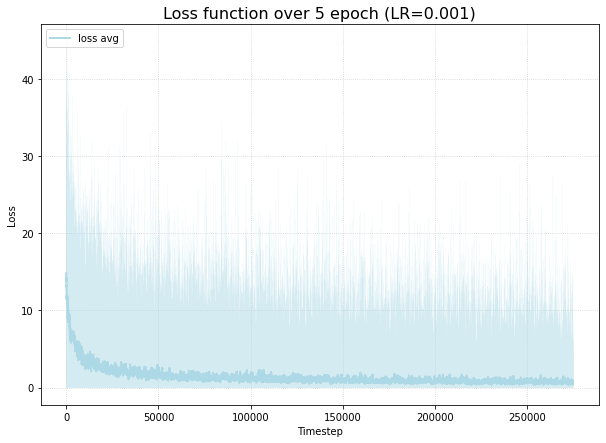

In [52]:
window = 200
avg_loss = []
for ind in range(len(dnn_lr001.all_losses) - 200 + 1):
    avg_loss.append(np.mean(dnn_lr001.all_losses[ind:ind+window]))

plt.figure(figsize=(10, 7))
plt.title('Loss function over 5 epoch (LR=0.001)',fontsize=16)

plt.xlabel('Timestep')
plt.ylabel('Loss')

plt.grid(alpha =.6, linestyle =':')
plt.plot(avg_loss,  'lightblue',linewidth=2,alpha=1,label='Running average')
plt.legend(labels =['loss avg'], fontsize=10,loc='upper left')
plt.plot(dnn_lr001.all_losses,'lightblue',linewidth=0.1,alpha=0.5,label='loss')

#####################################################################################################################


In [49]:
dnn = DNN()
random.seed(32)
# dnn.set_nodes(x=2,k=3,h=3,o=2,y=2)
# dnn.set_weights_W()
# dnn.set_weights_V()
# dnn.set_bias(b=3,c=2)
dnn.default_init()
# dnn.train_epoch(rounds=5,alpha=0.01,verbose=True)

dnn.train_epoch(rounds=None,alpha=0.05,verbose=False,epochs=1)


C:\Users\Martin\AppData\Local\Temp/ipykernel_20144/3482364818.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


epoch avgs: [4.419644901278301]


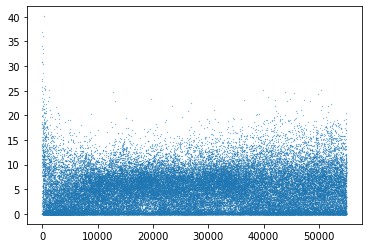

In [51]:
plt.scatter(range(len(dnn.all_losses)), dnn.all_losses, s=0.05)

C:\Users\Martin\AppData\Local\Temp/ipykernel_20144/3482364818.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


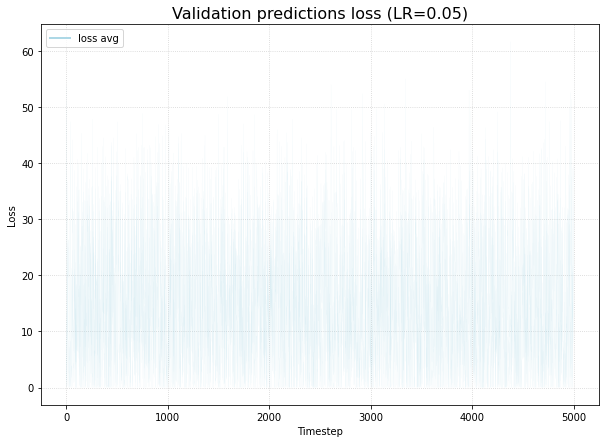

In [48]:
""" TRYING PREDICTIONS OVER VALIDATION"""
val_predictions_loss = []
for x,true_y in zip(dnn.xval,dnn.yval):        
    loss = dnn.forward_pass(x,true_y,verbose=False)
    
    val_predictions_loss.append(loss)

window = 200
val_avg_loss = []
for ind in range(len(dnn.all_losses) - 200 + 1):
    val_avg_loss.append(np.mean(val_predictions_loss[ind:ind+window]))

plt.figure(figsize=(10, 7))
plt.title('Validation predictions loss (LR=0.05)',fontsize=16)

plt.xlabel('Timestep')
plt.ylabel('Loss')

plt.grid(alpha =.6, linestyle =':')
plt.plot(val_avg_loss,  'lightblue',linewidth=2,alpha=1,label='Running average')
plt.legend(labels =['loss avg'], fontsize=10,loc='upper left')
plt.plot(val_predictions_loss,'lightblue',linewidth=0.1,alpha=0.5,label='loss')    


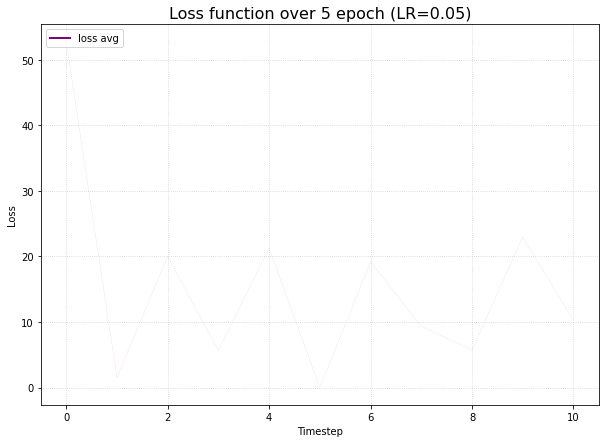

In [46]:
window = 200
avg_loss = []
for ind in range(len(dnn.all_losses) - 200 + 1):
    avg_loss.append(np.mean(dnn.all_losses[ind:ind+window]))

plt.figure(figsize=(10, 7))
plt.title('Loss function over 5 epoch (LR=0.05)',fontsize=16)

plt.xlabel('Timestep')
plt.ylabel('Loss')

plt.grid(alpha =.6, linestyle =':')
plt.plot(avg_loss,  'purple',linewidth=2,alpha=1,label='Running average')
plt.legend(labels =['loss avg'], fontsize=10,loc='upper left')
plt.plot(dnn.all_losses,'purple',linewidth=0.1,alpha=0.5,label='loss')

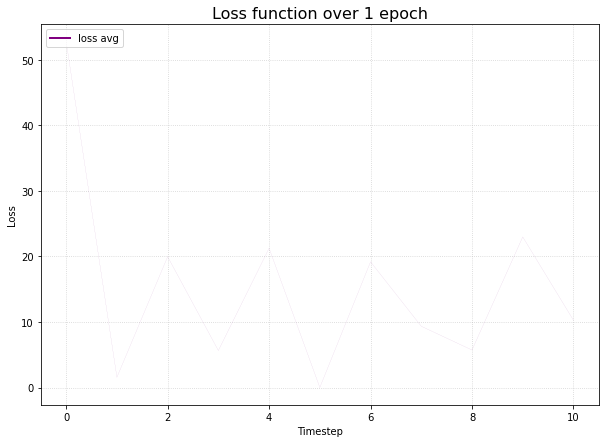

In [47]:
# FIRST RESULTS
window = 200
avg_loss = []
for ind in range(len(dnn.all_losses) - 200 + 1):
    avg_loss.append(np.mean(dnn.all_losses[ind:ind+window]))

plt.figure(figsize=(10, 7))
plt.title('Loss function over 1 epoch',fontsize=16)

plt.xlabel('Timestep')
plt.ylabel('Loss')

plt.grid(alpha =.6, linestyle =':')
plt.plot(avg_loss,  'purple',linewidth=2,alpha=1,label='Running average')
plt.legend(labels =['loss avg'], fontsize=10,loc='upper left')
plt.plot(dnn.all_losses,'purple',linewidth=0.1,alpha=0.5,label='loss')

In [ ]:
# type(q5_dnn.xtrain)
# print(np.unique(q5_dnn.xtrain))
print(f"number of training instances:     {len(dnn.xtrain)}")
print(f"number of input nodes:            {len(dnn.xtrain[0])}")
print(f"(given) number of output nodes:   10")
print(f"(given) hidden layer size:        300")

number of training instances:     60000
number of input nodes:            2
(given) number of output nodes:   10
(given) hidden layer size:        300


In [23]:
np.unique(dnn.ytrain)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)